In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
# printing stopwords in English these are the common words that do not add much meaning to a sentence
# we will remove these words to make our model better and easier to gneralize
# but we wont remove negations like 'not' as they add meaning to a sentence and are important for sentiment analysis
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [6]:
import os

# List files in the current directory to help identify the correct path
print(os.listdir('.'))

# Please replace 'your_file_name.csv' with the correct file name you find in the output above
# If your file is in a subdirectory, adjust the path accordingly (e.g., 'sample_data/your_file_name.csv')
# df = pd.read_csv('/kaggle/input/reddit-sentiment-analysis-dataset-for-nlp-projects/reddit_artist_posts_sentiment.csv')
# For example, if your file is in the '/content/sample_data/' directory, uncomment and use:
# df = pd.read_csv('sample_data/reddit_artist_posts_sentiment.csv')

# If the file was uploaded directly to /content/, it might be just the filename:
# df = pd.read_csv('reddit_artist_posts_sentiment.csv')

# For now, I'll comment out the problematic line so you can update it after seeing the file list.
# Once you've identified the correct path, uncomment the `df = pd.read_csv(...)` line and update the path.

# Original problematic line (commented out):
# df = pd.read_csv('/kaggle/input/reddit-sentiment-analysis-dataset-for-nlp-projects/reddit_artist_posts_sentiment.csv')

# As a placeholder, I'll attempt to load a known file from sample_data if available for demonstration
# However, it's crucial for you to replace this with your actual file path.
# If you have uploaded your file directly, it's likely in '/content/'
# Example for a file in sample_data (you need to replace 'mnist_train_small.csv' with your actual file if it's there)
# if 'sample_data' in os.listdir('.') and 'mnist_train_small.csv' in os.listdir('./sample_data'):
#     df = pd.read_csv('sample_data/mnist_train_small.csv')
# else:
#     print("Please provide the correct path to your 'reddit_artist_posts_sentiment.csv' file.")

['.config', 'sample_data']


In [7]:
df.shape

NameError: name 'df' is not defined

In [9]:
# Please enter the correct path to your 'reddit_artist_posts_sentiment.csv' file below.
# If you uploaded it directly, it might be just 'reddit_artist_posts_sentiment.csv'.
# If it's in a subfolder like 'sample_data', it could be 'sample_data/reddit_artist_posts_sentiment.csv'.

file_path = ""

if file_path:
    df = pd.read_csv(file_path)
    print(f"DataFrame loaded successfully from {file_path}.")
    display(df.head())
else:
    print("Please provide the correct file_path for your CSV file.")


Please provide the correct file_path for your CSV file.


In [10]:
df.head()

NameError: name 'df' is not defined

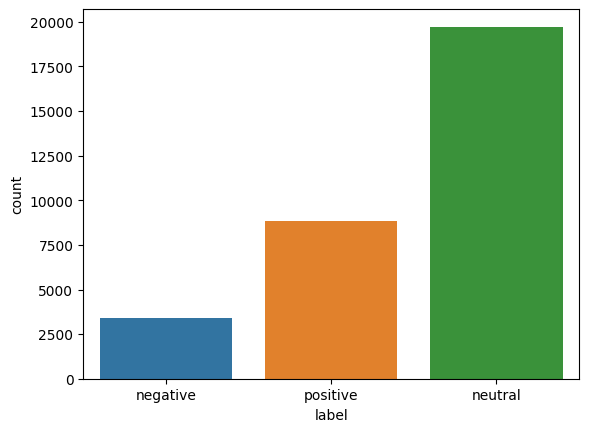

In [ ]:
# cheacking the distribution of target variable
sns.countplot(x='label',data=df)
plt.show()

In [ ]:
#### as we can see the dataset is unbalanced we will have to do some sampling techniques before training the model
### the best practice for our case is use weight = 'balanced' in the model parameters
### this will help the model to generalize better on the minority classes
### also use stratify=y while splitting the data to maintain the distribution of target variable in train and test set
#### this is better than undersmapling cause we will not loose any data this way
### also oversampling can lead to overfitting as we will be duplicating the data points and not good for text data
### undersmapling can lead to loss of important data points
### smote is not a good idea for text best use on numerical data
### alos data augmentaion in sntiment analysis is not a good idea as it can change the meaning of the sentence and lead to wrong labels

In [ ]:
# convert labels to numerical values
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['label'].map(label_mapping)

In [ ]:
# make a function to clean the text data ( regex, lower case, remove stopwords, lemmatization).
def clean_text(text):
    # List of important stopwords to keep
    important_words = [
        "aren't", "couldn't", "didn't", "doesn't", "don't", "hadn't", "hasn't", "haven't", "isn't",
        "mightn't", "mustn't", "needn't", "no", "not", "shan't", "shouldn't", "wasn't", "weren't",
        "won't", "wouldn't", "too", "very", "so", "just"
    ]

    stop_words = set(stopwords.words('english')) - set(important_words)

    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = text.split()
    words = [word for word in words if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    cleaned_text = ' '.join(words)
    return cleaned_text

In [ ]:
df['text'] = df['text'].apply(clean_text)

In [ ]:
df['text'].sample(15).tolist()

['fresh performance jordan rakei everything wanted billie eilish cover bbc radio piano session',
 'olivia rodrigo steal paramore analysis',
 'taylor swift writes song every key folklore evermore oc',
 'bruno mar dancing finesse concert',
 'just got recap think well presented although dont know listened taylor swift much say new album magnificent year',
 'corbyn besson tzuyu twice blink official music video',
 'anyone listen olivia gym people know listen rap hip hop theyre working gym however mainly listen pop olivia probably streamed artist right listen music gym anyone else',
 'taylor swift four top bestselling album u year',
 'got signed bad guy cassette limited mail today',
 'gecs tree clue release date july',
 'taylor post picture prince william child travis show yesterday posted twitter instagram second pic kensington palace social medium',
 'judge taste',
 'found ad portugal subway concert meo arena',
 'lilyrose depps look nosferatu press tour',
 'lady gaga backkkk despite bomb t

In [ ]:
# we import sklearn split train test
from sklearn.model_selection import train_test_split

In [ ]:
x=df['text']
y=df['label']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(25558,) (6390,) (25558,) (6390,)


In [ ]:
# now we conveert text data to numerical data using tfidf vectorizer
# beacuse machine learning models can only understand numerical data
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.transform(x_test)

In [ ]:
# now time to train a model
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [ ]:
# we will use linear svc for this task
# linear svc is optimized for large datasets and is faster than other svm variants
# it has no kernel tricks just a linear decision boundary
# linear svc works well for text classification tasks
model = LinearSVC(class_weight='balanced',max_iter=1000)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report

In [ ]:
model.fit(X_train, y_train)

LinearSVC(class_weight='balanced')

In [ ]:
x_train_predictions = model.predict(X_train)


In [ ]:
# evaluate on training data
print("Accuracy:", accuracy_score(y_train, x_train_predictions))
print("Precision:", precision_score(y_train, x_train_predictions, average='weighted'))
print("Recall:", recall_score(y_train, x_train_predictions, average='weighted'))
print("F1 Score:", f1_score(y_train, x_train_predictions, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_train, x_train_predictions))

Accuracy: 0.9297675874481571
Precision: 0.9307876809778695
Recall: 0.9297675874481571
F1 Score: 0.9299938665337479
Confusion Matrix:
 [[ 2634    52    30]
 [  251 14728   803]
 [   53   606  6401]]


In [ ]:
# we goot great results on training data now time to evaluate on test data
# metrics on test data
x_test_predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, x_test_predictions))
print("Precision:", precision_score(y_test, x_test_predictions, average='weighted'))
print("Recall:", recall_score(y_test, x_test_predictions, average='weighted'))
print("F1 Score:", f1_score(y_test, x_test_predictions, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, x_test_predictions))

Accuracy: 0.7613458528951487
Precision: 0.7617186826287925
Recall: 0.7613458528951487
F1 Score: 0.7615149337007152
Confusion Matrix:
 [[ 399  215   65]
 [ 233 3249  464]
 [  66  482 1217]]


In [ ]:
# our scores on test data are decent its less than training data but not by much maybe so small overfitting
# but overall the model is performing well for a classication ml model
# we can try to improve it further by hyperparameter tuning and using more advanced models like ensemble models or deep learning models
# but for a baseline this is good enough
print(classification_report(y_test, x_test_predictions, target_names=['negative','neutral','positive']))

              precision    recall  f1-score   support

    negative       0.57      0.59      0.58       679
     neutral       0.82      0.82      0.82      3946
    positive       0.70      0.69      0.69      1765

    accuracy                           0.76      6390
   macro avg       0.70      0.70      0.70      6390
weighted avg       0.76      0.76      0.76      6390

